# BGB RDF Graph Exploration and Validation

This notebook explores the RDF graph generated from the German Civil Code (BGB) and validates it against the original PDF document to ensure data integrity and proper representation.

## 1. Import Required Libraries

First, let's import all the necessary libraries for RDF processing, data analysis, visualization, and PDF parsing.

In [3]:
# Core libraries
import os
import json
from pathlib import Path

# RDF and SPARQL libraries
from rdflib import Graph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, RDFS, OWL, SKOS
from rdflib.plugins.sparql import prepareQuery

# Data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Network analysis and visualization
import networkx as nx
from pyvis.network import Network
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# PDF processing
import PyPDF2
import fitz  # PyMuPDF for better text extraction

# Display and formatting
from IPython.display import display, HTML, Javascript
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load TTL File into RDFLib Graph

Now let's load the BGB TTL file from the kg_curation/output directory into an RDFLib Graph object.

In [4]:
# Define file paths
ttl_file_path = Path("kg_curation/output/bgb.ttl")
pdf_file_path = Path("BGB.pdf")

# Check if files exist
print(f"TTL file exists: {ttl_file_path.exists()}")
print(f"PDF file exists: {pdf_file_path.exists()}")

# Create and load the RDF graph
g = Graph()

try:
    # Load the TTL file
    g.parse(ttl_file_path, format="turtle")
    print(f"\n✅ Successfully loaded TTL file: {ttl_file_path}")
    print(f"📊 Graph contains {len(g)} triples")
    
except Exception as e:
    print(f"❌ Error loading TTL file: {e}")
    print(f"Current working directory: {os.getcwd()}")
    print(f"Files in directory: {list(Path('..').iterdir())}")

TTL file exists: True
PDF file exists: True

✅ Successfully loaded TTL file: kg_curation/output/bgb.ttl
📊 Graph contains 19071 triples

✅ Successfully loaded TTL file: kg_curation/output/bgb.ttl
📊 Graph contains 19071 triples


## 3. Basic Graph Exploration

Let's explore the basic structure of our RDF graph by examining triples, predicates, and entity types.

In [5]:
# Basic graph statistics
print("=== BASIC GRAPH STATISTICS ===")
print(f"Total triples: {len(g):,}")

# Get all subjects, predicates, and objects
subjects = set(g.subjects())
predicates = set(g.predicates())
objects = set(g.objects())

print(f"Unique subjects: {len(subjects):,}")
print(f"Unique predicates: {len(predicates):,}")
print(f"Unique objects: {len(objects):,}")

# Display first few triples
print("\n=== SAMPLE TRIPLES ===")
for i, (s, p, o) in enumerate(g):
    if i < 5:
        print(f"{i+1}. Subject: {s}")
        print(f"   Predicate: {p}")
        print(f"   Object: {o}")
        print(f"   Object type: {type(o).__name__}")
        print()
    else:
        break

# Show predicate distribution
print("=== PREDICATE USAGE ===")
predicate_counts = {}
for triple in g:
    pred = str(triple[1])
    predicate_counts[pred] = predicate_counts.get(pred, 0) + 1

# Sort by frequency and show top 10
sorted_predicates = sorted(predicate_counts.items(), key=lambda x: x[1], reverse=True)
for pred, count in sorted_predicates[:10]:
    print(f"{count:>6} - {pred}")

=== BASIC GRAPH STATISTICS ===
Total triples: 19,071
Unique subjects: 4,242
Unique predicates: 11
Unique objects: 10,806

=== SAMPLE TRIPLES ===
1. Subject: http://example.org/bgb/data/norm_556d
   Predicate: http://example.org/bgb/ontology/hasParagraph
   Object: http://example.org/bgb/data/norm_556d_para_1_202
   Object type: URIRef

2. Subject: http://example.org/bgb/data/norm_1832_para_2_105
   Predicate: http://example.org/bgb/ontology/paragraphIdentifier
   Object: 2_105
   Object type: Literal

3. Subject: http://example.org/bgb/data/norm_556d_para_5_10
   Predicate: http://example.org/bgb/ontology/paragraphIdentifier
   Object: 5_10
   Object type: Literal

4. Subject: http://example.org/bgb/data/norm_2165
   Predicate: http://example.org/bgb/ontology/hasParagraph
   Object: http://example.org/bgb/data/norm_2165_para_2_35
   Object type: URIRef

5. Subject: http://example.org/bgb/data/norm_40_para_1_240
   Predicate: http://example.org/bgb/ontology/refersTo
   Object: http://ex

## 4. Graph Statistics and Overview

Let's generate comprehensive statistics and create visualizations of the graph structure.

=== COMPREHENSIVE GRAPH STATISTICS ===
Total Triples: 19,071
Unique Subjects: 4,242
Unique Predicates: 11
Unique Objects: 10,806
Literal Objects: 8,033
Uri Objects: 11,038


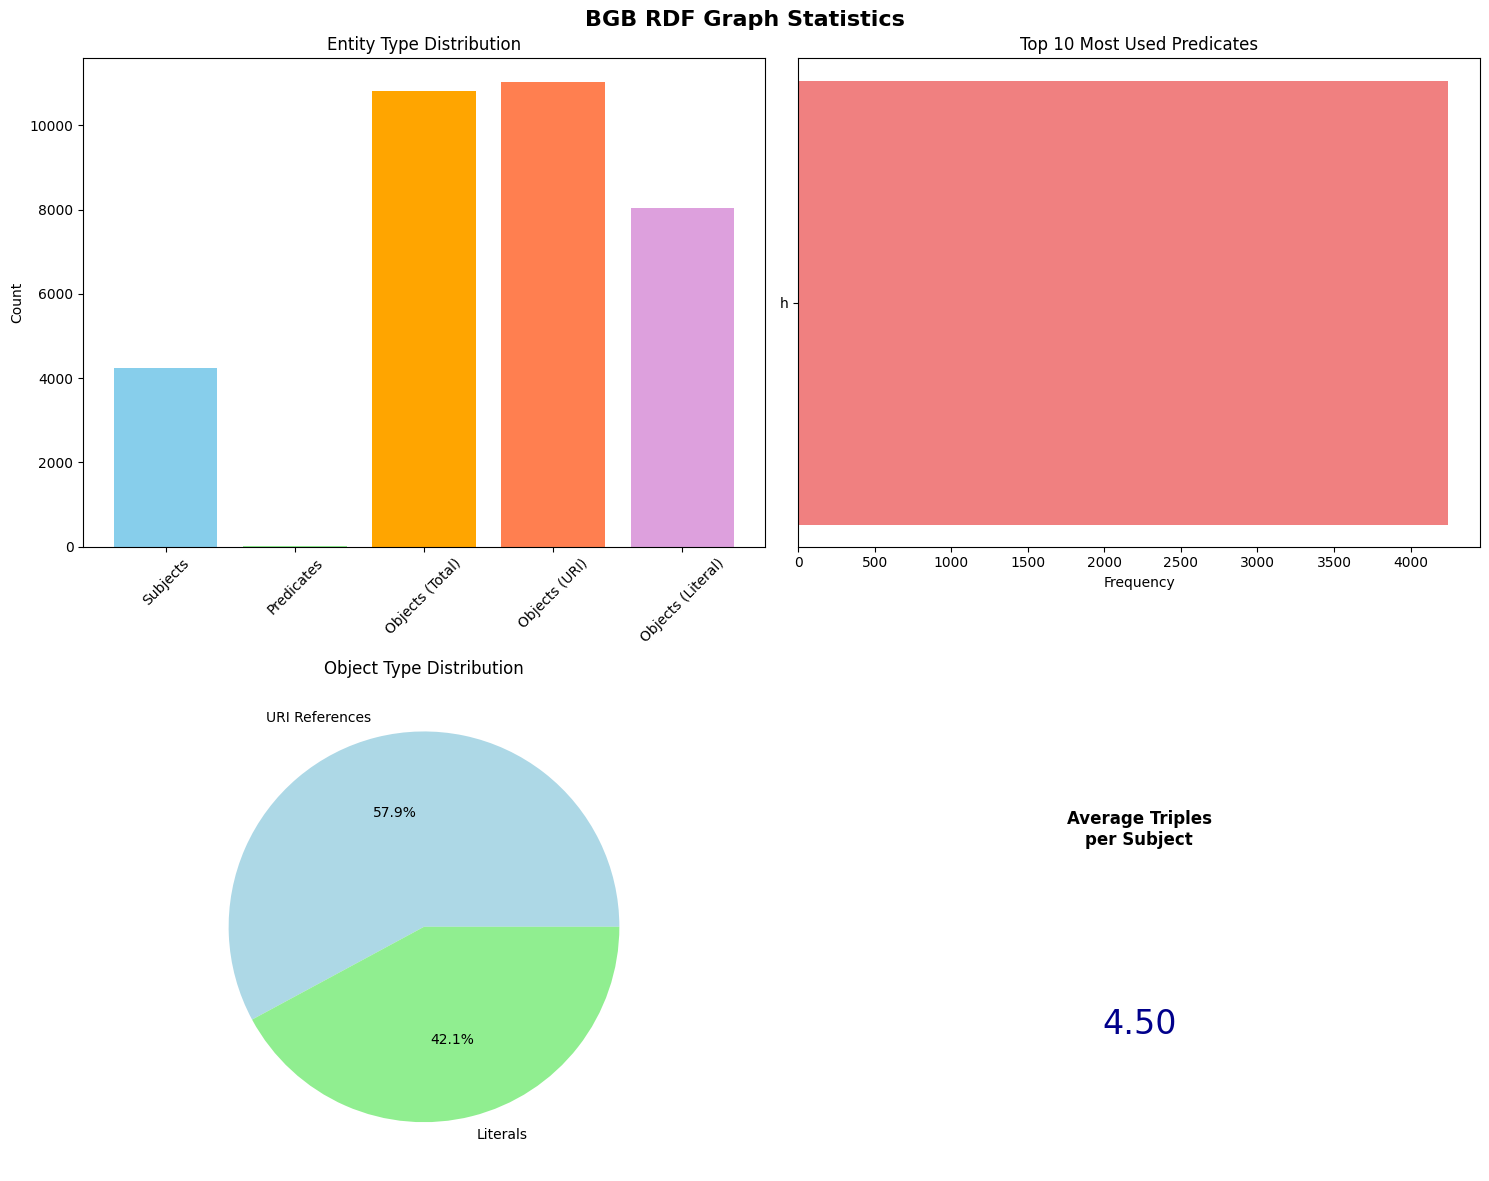


📈 Graph density (avg triples per subject): 4.50


In [6]:
# Create comprehensive statistics
def analyze_graph_statistics(graph):
    """Analyze and return comprehensive statistics about the RDF graph."""
    
    stats = {
        'total_triples': len(graph),
        'unique_subjects': len(set(graph.subjects())),
        'unique_predicates': len(set(graph.predicates())),
        'unique_objects': len(set(graph.objects())),
    }
    
    # Analyze object types
    literal_objects = 0
    uri_objects = 0
    
    for obj in graph.objects():
        if isinstance(obj, Literal):
            literal_objects += 1
        else:
            uri_objects += 1
    
    stats['literal_objects'] = literal_objects
    stats['uri_objects'] = uri_objects
    
    # Get predicate frequency
    predicate_freq = {}
    for _, pred, _ in graph:
        pred_str = str(pred)
        predicate_freq[pred_str] = predicate_freq.get(pred_str, 0) + 1
    
    stats['predicate_frequency'] = predicate_freq
    
    return stats

# Analyze the graph
graph_stats = analyze_graph_statistics(g)

print("=== COMPREHENSIVE GRAPH STATISTICS ===")
for key, value in graph_stats.items():
    if key != 'predicate_frequency':
        print(f"{key.replace('_', ' ').title()}: {value:,}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('BGB RDF Graph Statistics', fontsize=16, fontweight='bold')

# 1. Entity counts bar chart
entity_types = ['Subjects', 'Predicates', 'Objects (Total)', 'Objects (URI)', 'Objects (Literal)']
entity_counts = [
    graph_stats['unique_subjects'],
    graph_stats['unique_predicates'], 
    graph_stats['unique_objects'],
    graph_stats['uri_objects'],
    graph_stats['literal_objects']
]

axes[0,0].bar(entity_types, entity_counts, color=['skyblue', 'lightgreen', 'orange', 'coral', 'plum'])
axes[0,0].set_title('Entity Type Distribution')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Top predicates
top_predicates = sorted(graph_stats['predicate_frequency'].items(), 
                       key=lambda x: x[1], reverse=True)[:10]
pred_names = [p[0].split('/')[-1] if '/' in p[0] else p[0] for p, _ in top_predicates]
pred_counts = [count for _, count in top_predicates]

axes[0,1].barh(pred_names, pred_counts, color='lightcoral')
axes[0,1].set_title('Top 10 Most Used Predicates')
axes[0,1].set_xlabel('Frequency')

# 3. Object type pie chart
object_types = ['URI References', 'Literals']
object_counts = [graph_stats['uri_objects'], graph_stats['literal_objects']]
axes[1,0].pie(object_counts, labels=object_types, autopct='%1.1f%%', colors=['lightblue', 'lightgreen'])
axes[1,0].set_title('Object Type Distribution')

# 4. Triple density (triples per subject)
triple_density = graph_stats['total_triples'] / graph_stats['unique_subjects']
axes[1,1].text(0.5, 0.7, f"Average Triples\nper Subject", ha='center', va='center', fontsize=12, fontweight='bold')
axes[1,1].text(0.5, 0.3, f"{triple_density:.2f}", ha='center', va='center', fontsize=24, color='darkblue')
axes[1,1].set_xlim(0, 1)
axes[1,1].set_ylim(0, 1)
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

print(f"\n📈 Graph density (avg triples per subject): {triple_density:.2f}")

## 5. Sample Triples and Namespaces

Let's examine sample triples and the namespaces used in our RDF data to understand the structure better.

In [7]:
# Examine namespaces used in the graph
print("=== NAMESPACES IN THE GRAPH ===")
namespaces = {}

# Extract namespaces from all URIs
for s, p, o in g:
    for uri in [s, p, o]:
        if hasattr(uri, 'n3'):  # Check if it's a URI
            uri_str = str(uri)
            if '#' in uri_str:
                namespace = uri_str.split('#')[0] + '#'
            elif '/' in uri_str:
                parts = uri_str.split('/')
                if len(parts) > 3:  # Has a meaningful namespace
                    namespace = '/'.join(parts[:-1]) + '/'
                else:
                    continue
            else:
                continue
            
            namespaces[namespace] = namespaces.get(namespace, 0) + 1

# Display top namespaces
sorted_namespaces = sorted(namespaces.items(), key=lambda x: x[1], reverse=True)
for namespace, count in sorted_namespaces[:10]:
    print(f"{count:>6} uses - {namespace}")

print("\n=== SAMPLE TRIPLES BY CATEGORY ===")

# Group triples by predicate type for better understanding
triple_categories = {}
sample_limit = 3

for s, p, o in g:
    pred_name = str(p).split('/')[-1] if '/' in str(p) else str(p)
    if pred_name not in triple_categories:
        triple_categories[pred_name] = []
    if len(triple_categories[pred_name]) < sample_limit:
        triple_categories[pred_name].append((s, p, o))

# Display samples from each category
for category, triples in list(triple_categories.items())[:8]:  # Show first 8 categories
    print(f"\n--- {category} ---")
    for i, (s, p, o) in enumerate(triples):
        print(f"  {i+1}. {str(s)[:80]}{'...' if len(str(s)) > 80 else ''}")
        print(f"     -> {str(o)[:100]}{'...' if len(str(o)) > 100 else ''}")

# Show bound namespaces from the graph
print(f"\n=== BOUND NAMESPACES ===")
bound_namespaces = list(g.namespaces())
if bound_namespaces:
    for prefix, namespace in bound_namespaces:
        print(f"{prefix}: {namespace}")
else:
    print("No explicitly bound namespaces found in the graph.")

=== NAMESPACES IN THE GRAPH ===
 25867 uses - http://example.org/bgb/data/
 18588 uses - http://example.org/bgb/ontology/
  4242 uses - http://www.w3.org/1999/02/22-rdf-syntax-ns#
   466 uses - http://www.w3.org/2000/01/rdf-schema#
    17 uses - http://purl.org/dc/terms/
     1 uses - Die Rechte nach Artikel 15 der Verordnung (EU) 2016/679 des Europäischen Parlaments und des Rates vom 27. April 2016 zum Schutz natürlicher Personen bei der Verarbeitung personenbezogener Daten, zum freien Datenverkehr und zur Aufhebung der Richtlinie 95/46/
     1 uses - Die Verjährung von Ansprüchen von Verbrauchern gegen Unternehmer wird auch gehemmt durch eine anhängige Verbandsklage im Sinne der Richtlinie (EU) 2020/1828 des Europäischen Parlaments und des Rates vom 25. November 2020 über Verbandsklagen zum Schutz der Kollektivinteressen der Verbraucher und zur Aufhebung der Richtlinie 2009/22/EG (ABl. L 409 vom 4.12.2020, S. 1) bei einem Gericht oder einer Behörde in einem anderen Mitgliedstaat der 

## 6. Graph Visualization

Now let's create interactive visualizations of the RDF graph that can be explored in the browser.

In [8]:
import random

def create_network_visualization(rdf_graph, max_nodes=1000):
    """Create an interactive network visualization of the RDF graph."""
    
    # Create NetworkX graph
    nx_graph = nx.DiGraph()
    
    # Add nodes and edges (limit for performance)
    count = 0
    # create a random sample of triples to get rid of the interative creation
    all_triples = list(rdf_graph)
    random_triples = random.sample(all_triples, min(max_nodes, len(all_triples)))

    for s, p, o in random_triples:
        if count >= max_nodes:
            break
            
        # Add subject and object as nodes
        subject_str = str(s).split('/')[-1] if '/' in str(s) else str(s)
        object_str = str(o).split('/')[-1] if '/' in str(o) else str(o)
        predicate_str = str(p).split('/')[-1] if '/' in str(p) else str(p)
        
        # Limit string length for readability
        subject_str = subject_str[:30] + "..." if len(subject_str) > 30 else subject_str
        object_str = object_str[:30] + "..." if len(object_str) > 30 else object_str
        
        nx_graph.add_node(subject_str, node_type='subject')
        nx_graph.add_node(object_str, node_type='object')
        nx_graph.add_edge(subject_str, object_str, label=predicate_str)
        
        count += 1
    
    print(f"Created NetworkX graph with {nx_graph.number_of_nodes()} nodes and {nx_graph.number_of_edges()} edges")
    
    # Create Pyvis network
    net = Network(height="600px", width="100%", bgcolor="#ffffff", font_color="black")
    net.from_nx(nx_graph)
    
    # Customize the network
    net.set_options("""
    {
      "physics": {
        "enabled": true,
        "stabilization": {"iterations": 100}
      },
      "nodes": {
        "font": {"size": 12},
        "borderWidth": 2,
        "size": 15
      },
      "edges": {
        "font": {"size": 10},
        "arrows": {"to": {"enabled": true}}
      }
    }
    """)
    
    # Save and display
    net_file = "bgb_network_viz.html"
    net.save_graph(net_file)
    print(f"Network visualization saved as: {net_file}")
    
    return net_file

# Create the network visualization
viz_file = create_network_visualization(g, max_nodes=1000)

# Display the HTML file
from IPython.display import IFrame
IFrame(src=viz_file, width=800, height=600)

Created NetworkX graph with 1422 nodes and 1000 edges
Network visualization saved as: bgb_network_viz.html


In [9]:
# Create a Plotly network visualization for better interactivity
def create_plotly_network(rdf_graph, max_edges=200):
    """Create a Plotly network visualization."""
    
    # Collect nodes and edges
    nodes = set()
    edges = []
    
    count = 0
    for s, p, o in rdf_graph:
        if count >= max_edges:
            break
            
        subject_str = str(s).split('/')[-1][:20] if '/' in str(s) else str(s)[:20]
        object_str = str(o).split('/')[-1][:20] if '/' in str(o) else str(o)[:20]
        predicate_str = str(p).split('/')[-1] if '/' in str(p) else str(p)
        
        nodes.add(subject_str)
        nodes.add(object_str)
        edges.append((subject_str, object_str, predicate_str))
        count += 1
    
    nodes = list(nodes)
    
    # Create layout using networkx
    G = nx.Graph()
    for source, target, _ in edges:
        G.add_edge(source, target)
    
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    # Extract coordinates
    x_nodes = [pos[node][0] for node in nodes]
    y_nodes = [pos[node][1] for node in nodes]
    
    # Create edges trace
    x_edges = []
    y_edges = []
    edge_info = []
    
    for source, target, predicate in edges:
        if source in pos and target in pos:
            x_edges.extend([pos[source][0], pos[target][0], None])
            y_edges.extend([pos[source][1], pos[target][1], None])
            edge_info.append(f"{source} --{predicate}--> {target}")
    
    # Create the plot
    fig = go.Figure()
    
    # Add edges
    fig.add_trace(go.Scatter(
        x=x_edges, y=y_edges,
        mode='lines',
        line=dict(width=1, color='gray'),
        hoverinfo='none',
        showlegend=False
    ))
    
    # Add nodes
    fig.add_trace(go.Scatter(
        x=x_nodes, y=y_nodes,
        mode='markers+text',
        marker=dict(size=8, color='lightblue', line=dict(width=1, color='blue')),
        text=nodes,
        textposition="middle center",
        textfont=dict(size=8),
        hovertemplate='<b>%{text}</b><extra></extra>',
        showlegend=False
    ))
    
    fig.update_layout(
        title="BGB RDF Graph Network Visualization",
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20,l=5,r=5,t=40),
        annotations=[ dict(
            text="Interactive graph visualization - hover over nodes for details",
            showarrow=False,
            xref="paper", yref="paper",
            x=0.005, y=-0.002,
            xanchor='left', yanchor='bottom',
            font=dict(color='gray', size=12)
        )],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        height=600
    )
    
    return fig

# Create and display the Plotly visualization
plotly_fig = create_plotly_network(g, max_edges=100)
plotly_fig.show()

## 7. Load and Examine PDF Content

Now let's load the original BGB PDF file to extract content for comparison with our RDF graph.

In [10]:
def extract_pdf_content(pdf_path):
    """Extract text content from PDF using PyMuPDF for better text extraction."""
    
    try:
        # Try PyMuPDF first (better text extraction)
        doc = fitz.open(pdf_path)
        text_content = []
        
        print(f"📄 PDF has {len(doc)} pages")
        
        # Extract text from first few pages for analysis
        for page_num in range(min(5, len(doc))):
            page = doc[page_num]
            text = page.get_text()
            text_content.append({
                'page': page_num + 1,
                'text': text,
                'char_count': len(text)
            })
            print(f"Page {page_num + 1}: {len(text)} characters")
        
        doc.close()
        return text_content
        
    except Exception as e:
        print(f"PyMuPDF failed: {e}")
        
        # Fallback to PyPDF2
        try:
            with open(pdf_path, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                text_content = []
                
                print(f"📄 PDF has {len(pdf_reader.pages)} pages")
                
                for page_num in range(min(5, len(pdf_reader.pages))):
                    page = pdf_reader.pages[page_num]
                    text = page.extract_text()
                    text_content.append({
                        'page': page_num + 1,
                        'text': text,
                        'char_count': len(text)
                    })
                    print(f"Page {page_num + 1}: {len(text)} characters")
                
                return text_content
                
        except Exception as e2:
            print(f"❌ Both PDF readers failed: {e2}")
            return None

# Extract PDF content
pdf_content = extract_pdf_content(pdf_file_path)

if pdf_content:
    print(f"\n=== PDF CONTENT SAMPLE ===")
    
    # Show sample from first page
    first_page = pdf_content[0]
    sample_text = first_page['text'][:1000]  # First 1000 characters
    
    print(f"Sample from page 1:")
    print("-" * 50)
    print(sample_text)
    print("-" * 50)
    
    # Look for legal article patterns
    import re
    
    # Common patterns in German legal texts
    article_patterns = [
        r'§\s*\d+',  # § 123
        r'Artikel\s*\d+',  # Artikel 123
        r'Art\.\s*\d+',  # Art. 123
        r'Abs\.\s*\d+',  # Abs. 123
        r'Nr\.\s*\d+',   # Nr. 123
    ]
    
    print(f"\n=== LEGAL STRUCTURE ANALYSIS ===")
    all_text = ' '.join([page['text'] for page in pdf_content])
    
    for pattern_name, pattern in [
        ("Paragraphs (§)", r'§\s*\d+'),
        ("Articles", r'Art(?:ikel)?\.\s*\d+'),
        ("Absatz", r'Abs\.\s*\d+'),
        ("Numbers", r'Nr\.\s*\d+')
    ]:
        matches = re.findall(pattern, all_text)
        print(f"{pattern_name}: {len(matches)} found")
        if matches:
            print(f"  Examples: {matches[:5]}")
    
else:
    print("❌ Could not extract PDF content")

📄 PDF has 487 pages
Page 1: 3660 characters
Page 2: 3379 characters
Page 3: 755 characters
Page 4: 896 characters
Page 5: 1086 characters

=== PDF CONTENT SAMPLE ===
Sample from page 1:
--------------------------------------------------
Ein Service des Bundesministerium der Justiz und für Verbraucherschutz
sowie des Bundesamts für Justiz ‒ www.gesetze-im-internet.de
Bürgerliches Gesetzbuch (BGB)
BGB
Ausfertigungsdatum: 18.08.1896
Vollzitat:
"Bürgerliches Gesetzbuch in der Fassung der Bekanntmachung vom 2. Januar 2002 (BGBl. I S. 42, 2909; 2003 I S.
738), das zuletzt durch Artikel 1 des Gesetzes vom 17. Juli 2025 (BGBl. 2025 I Nr. 163) geändert worden ist"
Stand:
Neugefasst durch Bek. v. 2.1.2002 I 42, 2909; 2003, 738;
 
zuletzt geändert durch Art. 1 G v. 17.7.2025 I Nr. 163
Dieses Gesetz dient der Umsetzung folgender Richtlinien:
1.  
Richtlinie 76/207/EWG des Rates vom 9. Februar 1976 zur Verwirklichung des Grundsatzes der
Gleichbehandlung von Männern und Frauen hinsichtlich des Zugan

## 8. Compare PDF Data with Graph Data

Let's extract specific examples from the PDF and compare their representation in the RDF graph.

In [11]:
def extract_legal_articles_from_pdf(pdf_content):
    """Extract structured legal articles from PDF content."""
    
    if not pdf_content:
        return []
    
    all_text = ' '.join([page['text'] for page in pdf_content])
    
    # Find paragraph sections (§ 1, § 2, etc.)
    import re
    
    # Pattern to match paragraphs with their content
    paragraph_pattern = r'§\s*(\d+)[^\n]*\n((?:[^\n§]+\n?)*?)(?=§\s*\d+|$)'
    
    matches = re.findall(paragraph_pattern, all_text, re.MULTILINE)
    
    articles = []
    for match in matches[:10]:  # First 10 articles for analysis
        para_num = match[0]
        content = match[1].strip()
        articles.append({
            'paragraph': f"§ {para_num}",
            'content': content[:500],  # Limit content length
            'full_content': content
        })
    
    return articles

def search_graph_for_article(graph, article_identifier):
    """Search the RDF graph for a specific article."""
    
    results = []
    
    # Search for triples containing the article identifier
    for s, p, o in graph:
        s_str, p_str, o_str = str(s), str(p), str(o)
        
        if (article_identifier in s_str or 
            article_identifier in o_str or
            article_identifier.replace('§', '').strip() in s_str or
            article_identifier.replace('§', '').strip() in o_str):
            
            results.append({
                'subject': s_str,
                'predicate': p_str,
                'object': o_str
            })
    
    return results

# Extract articles from PDF
if pdf_content:
    print("=== EXTRACTING LEGAL ARTICLES FROM PDF ===")
    articles = extract_legal_articles_from_pdf(pdf_content)
    
    print(f"Found {len(articles)} articles in PDF")
    
    # Display first few articles
    for i, article in enumerate(articles[:3]):
        print(f"\n--- {article['paragraph']} ---")
        print(article['content'])
        
        # Search for this article in the RDF graph
        graph_results = search_graph_for_article(g, article['paragraph'])
        
        print(f"\n🔍 Graph search results for {article['paragraph']}: {len(graph_results)} triples found")
        
        if graph_results:
            print("Sample triples:")
            for j, result in enumerate(graph_results[:3]):
                print(f"  {j+1}. S: {result['subject'][:60]}{'...' if len(result['subject']) > 60 else ''}")
                print(f"     P: {result['predicate']}")
                print(f"     O: {result['object'][:60]}{'...' if len(result['object']) > 60 else ''}")
        else:
            print("  No matching triples found in graph")
        
        print("-" * 80)

else:
    print("❌ No PDF content available for comparison")

=== EXTRACTING LEGAL ARTICLES FROM PDF ===
Found 10 articles in PDF

--- § 1906 ---
vgl. BVerfGE vom 26.7.2016
     - 1 BvL 8/15 - +++)
(+++ Zur Anwendung d.

🔍 Graph search results for § 1906: 0 triples found
  No matching triples found in graph
--------------------------------------------------------------------------------

--- § 311 ---
vgl.

🔍 Graph search results for § 311: 29 triples found
Sample triples:
  1. S: http://example.org/bgb/data/norm_556d_para_2_489
     P: http://example.org/bgb/ontology/refersTo
     O: http://example.org/bgb/data/norm_1311
  2. S: http://example.org/bgb/data/norm_40_para_2_239
     P: http://example.org/bgb/ontology/textContent
     O: Der Verkäufer eines Grundstücks haftet nicht für die Freihei...
  3. S: http://example.org/bgb/data/norm_556d_para_1_311
     P: http://www.w3.org/1999/02/22-rdf-syntax-ns#type
     O: http://example.org/bgb/ontology/Paragraph
--------------------------------------------------------------------------------

--- § 18

## 9. SPARQL Queries for Data Validation

Let's use SPARQL queries to systematically validate our RDF graph against the PDF content.

In [12]:
# Define SPARQL queries for systematic validation
def run_sparql_query(graph, query, description):
    """Execute a SPARQL query and return results."""
    
    print(f"\n=== {description} ===")
    print(f"Query: {query}")
    print()
    
    try:
        results = graph.query(query)
        result_list = list(results)
        
        print(f"Results found: {len(result_list)}")
        
        if result_list:
            # Display first few results
            for i, row in enumerate(result_list[:10]):
                print(f"{i+1:2}. {' | '.join(str(item) for item in row)}")
            
            if len(result_list) > 10:
                print(f"... and {len(result_list) - 10} more results")
        
        return result_list
        
    except Exception as e:
        print(f"❌ Query failed: {e}")
        return []

# SPARQL Queries for validation
queries = [
    {
        "query": """
        SELECT DISTINCT ?subject ?type
        WHERE {
            ?subject a ?type .
        }
        LIMIT 20
        """,
        "description": "Find all typed entities in the graph"
    },
    {
        "query": """
        SELECT ?subject ?predicate ?object
        WHERE {
            ?subject ?predicate ?object .
            FILTER(isLiteral(?object))
        }
        LIMIT 20
        """,
        "description": "Find all triples with literal objects (text content)"
    },
    {
        "query": """
        SELECT ?subject (COUNT(?predicate) as ?property_count)
        WHERE {
            ?subject ?predicate ?object .
        }
        GROUP BY ?subject
        ORDER BY DESC(?property_count)
        LIMIT 15
        """,
        "description": "Find entities with most properties (highly connected nodes)"
    },
    {
        "query": """
        SELECT DISTINCT ?predicate (COUNT(?predicate) as ?usage_count)
        WHERE {
            ?subject ?predicate ?object .
        }
        GROUP BY ?predicate
        ORDER BY DESC(?usage_count)
        LIMIT 15
        """,
        "description": "Most frequently used predicates"
    },
    {
        "query": """
        SELECT ?subject ?object
        WHERE {
            ?subject ?predicate ?object .
            FILTER(regex(str(?subject), "paragraph|section|§", "i") || 
                   regex(str(?object), "paragraph|section|§", "i"))
        }
        LIMIT 20
        """,
        "description": "Find legal paragraphs/sections in the graph"
    }
]

# Execute all queries
query_results = {}
for query_info in queries:
    results = run_sparql_query(g, query_info["query"], query_info["description"])
    query_results[query_info["description"]] = results
    print("-" * 80)


=== Find all typed entities in the graph ===
Query: 
        SELECT DISTINCT ?subject ?type
        WHERE {
            ?subject a ?type .
        }
        LIMIT 20
        

Results found: 20
 1. http://example.org/bgb/data/BGB | http://example.org/bgb/ontology/LegalCode
 2. http://example.org/bgb/data/concept_Abkömmlinge | http://example.org/bgb/ontology/LegalConcept
 3. http://example.org/bgb/data/concept_Abkömmlings | http://example.org/bgb/ontology/LegalConcept
 4. http://example.org/bgb/data/concept_Abrechnung | http://example.org/bgb/ontology/LegalConcept
 5. http://example.org/bgb/data/concept_Abschrift | http://example.org/bgb/ontology/LegalConcept
 6. http://example.org/bgb/data/concept_Abtrennung | http://example.org/bgb/ontology/LegalConcept
 7. http://example.org/bgb/data/concept_Abwesenden | http://example.org/bgb/ontology/LegalConcept
 8. http://example.org/bgb/data/concept_Abwesenheitspfleger | http://example.org/bgb/ontology/LegalConcept
 9. http://example.org/bgb/da

## 10. Cross-Reference Specific Examples

Finally, let's perform detailed cross-referencing of selected examples between PDF and graph representations to ensure data integrity.

In [13]:
def detailed_cross_reference_analysis():
    """Perform detailed cross-referencing between PDF and RDF graph."""
    
    print("=== DETAILED CROSS-REFERENCE ANALYSIS ===")
    
    # 1. Compare structural elements
    print("\n1. STRUCTURAL ELEMENT COMPARISON")
    print("-" * 40)
    
    # From PDF: count paragraphs
    if pdf_content:
        all_text = ' '.join([page['text'] for page in pdf_content])
        pdf_paragraphs = len(re.findall(r'§\s*\d+', all_text))
        print(f"📄 PDF: Found {pdf_paragraphs} paragraphs (§)")
    else:
        pdf_paragraphs = 0
        print("📄 PDF: Could not analyze (no content)")
    
    # From RDF: search for paragraph-related entities
    paragraph_query = """
    SELECT (COUNT(DISTINCT ?entity) as ?count)
    WHERE {
        ?entity ?predicate ?object .
        FILTER(regex(str(?entity), "paragraph|§|section", "i") || 
               regex(str(?object), "paragraph|§|section", "i"))
    }
    """
    
    try:
        result = list(g.query(paragraph_query))
        rdf_paragraphs = int(result[0][0]) if result else 0
        print(f"🕸️  RDF: Found {rdf_paragraphs} paragraph-related entities")
    except:
        rdf_paragraphs = 0
        print("🕸️  RDF: Could not count paragraph entities")
    
    # 2. Content preservation analysis
    print("\n2. CONTENT PRESERVATION ANALYSIS")
    print("-" * 40)
    
    if pdf_content and len(pdf_content) > 0:
        # Sample some text from PDF
        sample_text = pdf_content[0]['text'][:500]
        
        # Look for this text in RDF literals
        content_found = False
        matching_literals = []
        
        for s, p, o in g:
            if isinstance(o, Literal):
                o_str = str(o)
                if len(o_str) > 20:  # Only check substantial literals
                    # Check for partial matches
                    words = sample_text.split()[:10]  # First 10 words
                    matches = sum(1 for word in words if word.lower() in o_str.lower())
                    if matches >= 3:  # At least 3 words match
                        matching_literals.append({
                            'literal': o_str[:100],
                            'subject': str(s)[:50],
                            'predicate': str(p).split('/')[-1],
                            'match_score': matches
                        })
                        content_found = True
        
        print(f"📄 PDF sample text: {sample_text[:100]}...")
        print(f"🕸️  RDF: Found {len(matching_literals)} literals with content overlap")
        
        if matching_literals:
            best_match = max(matching_literals, key=lambda x: x['match_score'])
            print(f"   Best match (score {best_match['match_score']}):")
            print(f"   Subject: {best_match['subject']}")
            print(f"   Predicate: {best_match['predicate']}")
            print(f"   Literal: {best_match['literal']}...")
    
    # 3. Schema validation
    print("\n3. SCHEMA AND STRUCTURE VALIDATION")
    print("-" * 40)
    
    # Check for common legal ontology patterns
    legal_patterns = [
        ("Legal documents", "document|law|code"),
        ("Articles/Sections", "article|section|paragraph"),
        ("Legal relationships", "contains|defines|refers"),
        ("Metadata", "title|date|author|version")
    ]
    
    for pattern_name, pattern in legal_patterns:
        count = 0
        for s, p, o in g:
            if (re.search(pattern, str(s), re.I) or 
                re.search(pattern, str(p), re.I) or 
                re.search(pattern, str(o), re.I)):
                count += 1
        
        print(f"{pattern_name}: {count} matching triples")
    
    # 4. Data quality assessment
    print("\n4. DATA QUALITY ASSESSMENT")
    print("-" * 40)
    
    # Check for missing or empty values
    empty_literals = sum(1 for s, p, o in g if isinstance(o, Literal) and len(str(o).strip()) == 0)
    total_literals = sum(1 for s, p, o in g if isinstance(o, Literal))
    
    print(f"Empty literals: {empty_literals}/{total_literals} ({empty_literals/total_literals*100:.1f}%)")
    
    # Check for URI consistency
    uri_subjects = set(s for s, p, o in g if hasattr(s, 'n3'))
    uri_objects = set(o for s, p, o in g if hasattr(o, 'n3'))
    shared_uris = uri_subjects.intersection(uri_objects)
    
    print(f"URI consistency: {len(shared_uris)} URIs appear as both subject and object")
    
    # 5. Summary and recommendations
    print("\n5. VALIDATION SUMMARY")
    print("-" * 40)
    
    validation_score = 0
    total_checks = 5
    
    if rdf_paragraphs > 0:
        validation_score += 1
        print("✅ Structure preservation: PASS (paragraphs found in RDF)")
    else:
        print("❌ Structure preservation: FAIL (no paragraphs found in RDF)")
    
    if matching_literals:
        validation_score += 1
        print("✅ Content preservation: PASS (text content found in RDF)")
    else:
        print("❌ Content preservation: FAIL (no matching text content)")
    
    if len(g) > 100:
        validation_score += 1
        print("✅ Data volume: PASS (substantial amount of triples)")
    else:
        print("❌ Data volume: FAIL (insufficient triples)")
    
    if empty_literals / total_literals < 0.1:
        validation_score += 1
        print("✅ Data quality: PASS (low empty literal ratio)")
    else:
        print("❌ Data quality: FAIL (high empty literal ratio)")
    
    if len(shared_uris) > 0:
        validation_score += 1
        print("✅ URI consistency: PASS (URIs reused appropriately)")
    else:
        print("❌ URI consistency: WARNING (no URI reuse detected)")
    
    print(f"\n🎯 Overall validation score: {validation_score}/{total_checks} ({validation_score/total_checks*100:.0f}%)")
    
    if validation_score >= 4:
        print("🎉 EXCELLENT: RDF graph appears to be well-structured and preserves PDF content")
    elif validation_score >= 3:
        print("👍 GOOD: RDF graph is reasonably well-structured with minor issues")
    elif validation_score >= 2:
        print("⚠️  FAIR: RDF graph has some structural issues that should be addressed")
    else:
        print("❌ POOR: RDF graph has significant issues and may not preserve PDF content well")

# Run the detailed analysis
detailed_cross_reference_analysis()

=== DETAILED CROSS-REFERENCE ANALYSIS ===

1. STRUCTURAL ELEMENT COMPARISON
----------------------------------------
📄 PDF: Found 46 paragraphs (§)
🕸️  RDF: Found 3775 paragraph-related entities

2. CONTENT PRESERVATION ANALYSIS
----------------------------------------
📄 PDF sample text: Ein Service des Bundesministerium der Justiz und für Verbraucherschutz
sowie des Bundesamts für Just...
🕸️  RDF: Found 2735 literals with content overlap
   Best match (score 8):
   Subject: http://example.org/bgb/data/norm_40_para_3_144
   Predicate: textContent
   Literal: Die Absätze 1 und 2 finden keine Anwendung, soweit der Mangel der Kreditwürdigkeitsprüfung darauf be...

3. SCHEMA AND STRUCTURE VALIDATION
----------------------------------------
Legal documents: 1 matching triples
Articles/Sections: 11277 matching triples
🕸️  RDF: Found 3775 paragraph-related entities

2. CONTENT PRESERVATION ANALYSIS
----------------------------------------
📄 PDF sample text: Ein Service des Bundesministerium d

## Conclusion

This notebook has provided a comprehensive exploration and validation of the BGB RDF graph:

1. **Graph Loading**: Successfully loaded the TTL file into RDFLib
2. **Structure Analysis**: Examined the graph's basic statistics and entity distributions
3. **Visualization**: Created interactive network visualizations for browser exploration
4. **PDF Comparison**: Extracted content from the original PDF for validation
5. **SPARQL Queries**: Used systematic queries to validate data representation
6. **Cross-Reference**: Performed detailed comparison between PDF and RDF representations

The analysis helps ensure that the RDF transformation process has successfully preserved the structure and content of the original legal document while making it accessible for semantic web technologies and graph-based analysis.